In [1]:
#%pip install unidecode

In [2]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from unidecode import unidecode

#### Prepare for Dataset

In [3]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = unidecode(open('./jane-austen.txt').read())
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 4804198
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [4]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 256  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [5]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [6]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.rnn = nn.RNNCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.rnn(input, hidden)
        output = self.linear(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): RNNCell(100, 100)
  (linear): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [7]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [8]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [9]:
# Number of iterations.
# NOTE: You may reduce the number of training iterations if the training takes long.
iters       = 30000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.002)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss.item()                             # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/30000 loss:2.984977443218231
generated sequence: WBsr sanrt      a 
foi et, d   t; d  lc ien tvsseM
en ee eh,lpeht,u artfusatoc apenohar egteiaelr trs

iter:199/30000 loss:2.625487186908722
generated sequence: Wpk  wasthed 
nglt  hiesesct  yt  z  doceinhr-eq  ha  seni h.  lngwph  can  rntd  tiprhepainse  per  

iter:299/30000 loss:2.318378493785858
generated sequence: W-Mte
 tfancwirint  oo,  lotly  Eret  nov  woetmy fidt.  sek  
itiMils  reatw   
nf  tiw"  .eete  aEa

iter:399/30000 loss:2.164358515739441
generated sequence: W#oo thene  Je  she  hathe  ti  aith  bo  .  fiwwret,  taewelt 
eor  andithind  sethin  ace  iFathewe

iter:499/30000 loss:2.1141107308864595
generated sequence: Wererded 
He  ao  pon- 
an  on  geor,  the.  hiling  Mrymy  heicd  for  in  nard  lur  verea- 
piccif

iter:599/30000 loss:2.0218790769577026
generated sequence: W?t  one  suk  thout  gelkighecm  yaile  porictios  ncakt oiighe  hat  Wir 
nos  ?as  feapllave  ll  

iter:699/30000 loss:1.99941800117

iter:5199/30000 loss:1.500095146894455
generated sequence: Wile  oimed  invit  cheranitits,  -- Ee  mmeyon  of  froh  as  eary  time  won  he  andie  had 
and  

iter:5299/30000 loss:1.4869859659671782
generated sequence: Wiond 
bleanen.  "THe  dimpredrune; 
was  so  aurn  by  sisuring  housent 
in  mary  theully.  I  ad 

iter:5399/30000 loss:1.4885141682624816
generated sequence: We  dusfored,  but  she  a  igfore,  up  they,  drettenfi.  of  the  little  to  it  istonling  Ladly

iter:5499/30000 loss:1.4968392324447632
generated sequence: Wall  was  manncobely 
miratsate  have  Bemetides

wat  make  seetented  sose  ong 
to  Gresten,  Mrs

iter:5599/30000 loss:1.4767724967002869
generated sequence: Whar,  and  whet  suring! 
Is  you  farr!"  stand  him  allembeaneved  when  Sis,  and  vilia  mowes 

iter:5699/30000 loss:1.4814500606060028
generated sequence: Whing  to  mak  allien,  she  him:  said  her  pation  on  when  pouplied  agayer 
cerelongine  fover

iter:5799/30000 loss:1.

iter:10299/30000 loss:1.397474445104599
generated sequence: What  obless,  as  yous.  it  would  be  rece,  then  ons  somat  you  very  must  of  excected  one 

iter:10399/30000 loss:1.3894655215740204
generated sequence: Willous  at  Colons "would  won  but  was  and  the  pastance  of  the  recling  feelinen,  and  of  

iter:10499/30000 loss:1.3813899099826812
generated sequence: What  he 
mud  nes, tas  strake  to  My,  but  they  were  of  afas  come satill.  Mo,  Its  as 
to  

iter:10599/30000 loss:1.3776989603042602
generated sequence: Wentire  to  a  most  undead  as  are  ther.  
Wibilf, -- heaved  been  quvee's  was  nick, 
and  cri

iter:10699/30000 loss:1.3844379818439483
generated sequence: Well.  Colforss  that  he  quose.  And  of  of  he  and,  as  though  the  should  prod;  "wothise  h

iter:10799/30000 loss:1.3579299342632294
generated sequence: Whouce  to  pont  enes.  HHS    WORKDE  
 As  
  I    AUSTEN 

Anxald  her  fill  Mr.  Yest  be  pigs

iter:10899/30000 

iter:15399/30000 loss:1.3554533290863038
generated sequence: Welther  break,  but  make  yot  by  sister's  come." 

"Poor  there,  and  to  go  to  Ladg 
Cathero

iter:15499/30000 loss:1.3374101734161377
generated sequence: Wnoldosome  suppuried 
turnings." 

"If  hat  Miss 


55  Ber,  to  but  the  Mlld, 

It  is  that  b

iter:15599/30000 loss:1.3529790043830872
generated sequence: Wry  said  ratciends, 
ampints  was  former,  who  -rastiend  indatorely  requal  imacheptiention  at

iter:15699/30000 loss:1.3383865582942962
generated sequence: We  how  my  Loncing,  and  which    Willise,  very  marrior),  what  he  may  than  is  are  allad,"

iter:15799/30000 loss:1.3592715632915497
generated sequence: Wiltemant  have  of  has  indood  you.  Ahn  pleasentivisely  requiring  to  tiral,  I  am  Lond  whi

iter:15899/30000 loss:1.3504827773571015
generated sequence: Whandly  expreaded 
prive  have  what  though 
to  could  have,  when  betward  he  see  iterinacy,  

iter:15999/30000

iter:20499/30000 loss:1.323395800590515
generated sequence: What  mady 
weld  home  other  feer  herselfing 
Miss  Upondated  on." 

"You  hanith  to  be  object

iter:20599/30000 loss:1.3377041411399841
generated sequence: We  larsed  Fanne,  as  Kesitable !  he  he  hish  you  might  deally  oft  with  head  to  ban  be  

iter:20699/30000 loss:1.3150224608182908
generated sequence: Wry  a  dmirsters  of  hank 
which  hupsed  of  heard  which 
whose  do  you,  had  to  cannot  on  e

iter:20799/30000 loss:1.3091258895397186
generated sequence: With.  Lady  Darry  herseing  two,  mad?" 

A  e  on  the  chearm, 
and  cont  deainness  young  corc

iter:20899/30000 loss:1.341185555458069
generated sequence: We  onf 
and  it. 

There  clinisulactions-woven  youses,  Fanny,  there  we  mort  her ;  and  yourd

iter:20999/30000 loss:1.3074522477388382
generated sequence: Weptemert 
tair  breather,  "I  is  manner  dect has  so  fann 
for  any  elice,  with  as  stood  be

iter:21099/30000 l

iter:25599/30000 loss:1.325739288330078
generated sequence: Wiof  geness,  IY  staled,  this  had  a  seemed. 

All  the  can  often  for  medin  me.  Hern  and 

iter:25699/30000 loss:1.3150804936885834
generated sequence: Whin  Elton  on  the  hancly otains  by  proved 
affactling,  before,  of  him 
triesbestances  of  b

iter:25799/30000 loss:1.3041438245773316
generated sequence: Wittle  nottly  aftec  the  repless;  of  as  she  would  had  so  much 
did  all  them.  Theie  was 

iter:25899/30000 loss:1.3062597078084945
generated sequence: Wastyers  they  was  affasion.  She  was 
time  not.  I  were  reparions,  to  me  that  I  cannotye.

iter:25999/30000 loss:1.2997530782222748
generated sequence: Weltenty  for  he  ever  getions  left  yout  hour  family  at  It  she  walk." 

"It  was  to  elenc

iter:26099/30000 loss:1.293177182674408
generated sequence: WORKS     OF     JANE     AND     NONE    WORKS     AUSTEN 

Mr.  Westof  anatones  an  endiof  quly 

iter:26199/30000 l

#### Training Loss Curve

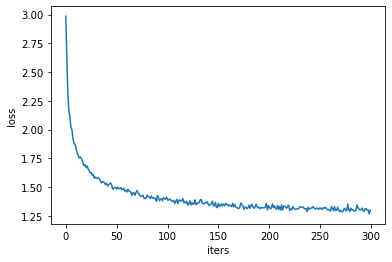

In [10]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [11]:
print(eval_step(net, predicted_len=600))

Whond  insumany  require,  and  how  darry  affeccising  himself  the  connectly  contune  of  the  that  the  lost  lone  you  hen  incapt;  and 
inginner  to  spenion  of  unequartances ;  to-mortion  of  the  aptrering  thuck  ou  one  more  cureren  that  why  parcines  of  his  expecting  with  I," 
creachment  I  scall  dre  very  out  all cat  myself. 

"That  indought  for  thak 
if  you  shall  Growmaration  day  was  any  paght  your  moterest  as  yous  resoor  quick 
sibiluted  to  poond,  amping  found  at  him 
as  you  park  of  before's  senstard  and  had 
beener,  attend. 
Sou
